Mounting Notebook onto Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Bigram and Trigram Processing for Both Twitter and Wikipedia Data

In [0]:
pip install gensim

In [0]:
import spacy
import pandas as pd
import itertools as it
import os
import codecs
import string
import re
import time

In [0]:
nlp = spacy.load('en')

In [0]:
# Read data
twitter_data = pd.read_csv('/content/drive/My Drive/data.csv', encoding = "ISO-8859-1")

# Drop the unneeded columns
twitter_data.drop(['Unnamed: 0','description','url','crawled_at','protected','listed_count','last_post_lat','last_post_lon','last_post_place_id'], axis=1,inplace=True)

# Drop N/A values 
twitter_data.dropna(axis=0, subset= ['last_post_text'],inplace=True)

# Create a dataframe that only contained "directed" relationships
twitter_data['directed'] = twitter_data['last_post_text'].str.contains('@')
twitter_data_directed = twitter_data[twitter_data['directed'] == True]

# Clean the text

def clean_words(string):
  string = string.replace("\n"," ")
  string = re.sub(r'\d+','',string)
  string = string.strip()
  return string 

twitter_data_directed['last_post_text'] = twitter_data_directed['last_post_text'].apply(clean_words)

# Create a column that showed the accounts that are tagged in the text
def get_users(comment):
  id = ''
  for token in comment.split():
    if "@" in token:
      id = id + (token.strip("@")) + ' '
  return id

twitter_data_directed['directed_to_no_list'] = twitter_data_directed['last_post_text'].apply(get_users)


# Store the dataframe in Google Drive
from google.colab import files
twitter_data_directed.to_csv('/content/drive/My Drive/twitter_data_directed.csv')
files.download('twitter_data_directed.csv')

In [0]:
#Read in Data

df = pd.read_csv('/content/drive/My Drive/train.csv')
twitter = pd.read_csv('/content/drive/My Drive/twitter_data_directed.csv')

#Clean Data & Preprocessing

def clean_printable(string_2):
  printable = set(string.printable)
  returned = ''.join(filter(lambda x: x in printable, string_2))
  return(returned)

twitter['last_post_text'] = twitter.last_post_text.astype(str)
twitter['last_post_text'] = twitter['last_post_text'].apply(clean_printable)
twitter = twitter[twitter['language'] == 'en']
twitter_text = twitter[['account_id','last_post_text']]
#twitter_text.to_csv("/content/drive/My Drive/Twitter_en.csv")

def clean_words(string):
  string = string.replace("\n"," ")
  string = string.replace("/n"," ")
  string = string.replace("\n\n"," ")
  string = string.replace("\n\n\n"," ")
  #string = string.replace("@"," ")
  string = re.sub(r'\d', '', string)

  #this cleans out links
  string = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", string)
  string = string.strip()
  return string 

twitter_text['last_post_text'] = twitter_text['last_post_text'].apply(clean_words)
df['comment_text'] = df['comment_text'].apply(clean_words)

In [0]:
#Write all the text into one file (Do this for Twitter Data too) The below code is credited to Prof Abrahao's Network Analytics Lecture

bully = df[df['toxic'] == 1]['comment_text']
no_bully = df[df['toxic'] == 0]['comment_text']

comments_bully = open('/content/drive/My Drive/comments_bully.txt','w+')
comments_no_bully = open('/content/drive/My Drive/comments_no_bully.txt','w+')


for i in list(bully):
  comments_bully.write(i)
  comments_bully.write("\n")
comments_bully.close()

for i in list(no_bully):
  comments_no_bully.write(i)
  comments_no_bully.write("\n")
comments_no_bully.close()

In [0]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_review(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [0]:
unigram_sentences_bully_filepath = '/content/drive/My Drive/unigram_sentences_all_bully.txt'
review_txt_bully_filepath = '/content/drive/My Drive/comments_bully.txt'

unigram_sentences_nobully_filepath = '/content/drive/My Drive/unigram_sentences_all_nobully.txt'
review_txt_nobully_filepath = '/content/drive/My Drive/comments_no_bully.txt'

In [0]:
with codecs.open(unigram_sentences_nobully_filepath, 'w', encoding='utf_8') as f:
  for sentence in lemmatized_sentence_corpus(review_txt_nobully_filepath):
    f.write(sentence + '\n')    

#Do the same for bully set

In [0]:
unigram_sentences_nobully = LineSentence(unigram_sentences_nobully_filepath)
for unigram_sentence in it.islice(unigram_sentences_nobully, 100, 120):
    print (u' '.join(unigram_sentence))
    print (u'')

In [0]:
%%time
bigram_model_filepath_nobully = '/content/drive/My Drive/bigram_model_all_nobully'

bigram_model_nobully = Phrases(unigram_sentences_nobully)

bigram_model_nobully.save(bigram_model_filepath_nobully)

In [0]:
bigram_sentences_filepath_nobully = '/content/drive/My Drive/bigram_sentences_all_nobully.txt'

In [0]:
%%time
if 1 == 1:
    with codecs.open(bigram_sentences_filepath_nobully, 'w', encoding='utf_8') as f:
        for unigram_sentence in unigram_sentences_nobully:
            bigram_sentence_nobully = u' '.join(bigram_model_nobully[unigram_sentence])
            f.write(bigram_sentence_nobully + '\n')

In [0]:
bigram_sentences_nobully = LineSentence(bigram_sentences_filepath_nobully)
trigram_model_nobully_filepath = '/content/drive/My Drive/trigram_model_all_nobully'

if 1 == 1:
    trigram_model_nobully = Phrases(bigram_sentences_nobully)
    trigram_model_nobully.save(trigram_model_nobully_filepath)

In [0]:
trigram_sentences_nobully_filepath = '/content/drive/My Drive/trigram_sentences_no_bully.txt'

with codecs.open(trigram_sentences_nobully_filepath, 'w', encoding='utf_8') as f:
        for bigram_sentence in bigram_sentences_nobully:
            trigram_sentence_nobully = u' '.join(trigram_model_nobully[bigram_sentence])
            f.write(trigram_sentence_nobully + '\n')

trigram_sentences_nobully = LineSentence(trigram_sentences_nobully_filepath)

In [0]:
trigram_reviews_nobully_filepath = '/content/drive/My Drive/trigram_transformed_reviews_all_nobully.txt'

if 1 == 1:

    with codecs.open(trigram_reviews_nobully_filepath, 'w', encoding='utf_8') as f:
        
        for parsed_review in nlp.pipe(line_review(review_txt_nobully_filepath),
                                      batch_size=10000, n_threads=7):
            
            # lemmatize the text, removing punctuation and whitespace
            unigram_review = [token.lemma_ for token in parsed_review
                              if not punct_space(token)]
            
            # apply the first-order and second-order phrase models
            bigram_review = bigram_model_nobully[unigram_review]
            trigram_review = trigram_model_nobully[bigram_review]
            
            # remove any remaining stopwords
            trigram_review = [term for term in trigram_review
                              if term not in spacy.lang.en.stop_words.STOP_WORDS] 
            
            # write the transformed review as a line in the new file
            trigram_review = u' '.join(trigram_review)
            f.write(trigram_review + '\n')

Getting Top N-Grams as Features

In [0]:
data = open(trigram_reviews_bully_filepath, 'r').read()
data_nobully = open(trigram_reviews_nobully_filepath,'r').read()
data_twitter= open(trigram_reviews_twitter_filepath,'r').read()

In [0]:
%%time

from collections import Counter
nlp = spacy.load("en")
nlp.max_length = 4000000

text = data
doc = nlp(text,disable = ['ner', 'parser'])
words = [token.text for token in doc]
word_freq = Counter(words)
common_words = word_freq.most_common(1000)

In [0]:
columns = [x[0] for x in common_words]

list_to_remove = ['-PRON-','\n','=','_']

for i in list_to_remove:
  columns.remove(i)

In [0]:
#Convert text files into DataFrame

df_cleaned = pd.DataFrame([x for x in data.split('\n')])
df_nobully = pd.DataFrame([x for x in data_nobully.split('\n')])
df_cleaned.columns = ['comment_text']
df_nobully.columns = ['comment_text']
df_cleaned['label'] = 1
df_nobully['label'] = 0

whole_df = pd.concat([df_cleaned,df_nobully])
sampled_df = whole_df.sample(n=100000,random_state=1)

df_twitter = pd.DataFrame([x for x in data_twitter.split('\n')])
df_twitter.columns = ['comment_text']

In [0]:
#This is time-consuming. It gets the count of n-grams for each comment

for token in columns[0:500]:
  sampled_df[token] = sampled_df.apply(lambda x: x['comment_text'].count(token),axis=1)
  df_twitter[token] = df_twitter.apply(lambda x: x['comment_text'].count(token),axis=1)

sampled_df.to_csv('/content/drive/My Drive/sampled_df')
df_twitter.to_csv('/content/drive/My Drive/df_twitter')

Running Naive-Bayes Classifier

In [0]:
#Read in Previous Data
sampled_df = pd.read_csv('/content/drive/My Drive/sampled_df.csv')
twitter_df = pd.read_csv('/content/drive/My Drive/df_twitter')

In [0]:
#Import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [0]:
#Train-test Split

Y = sampled_df['label']
X = sampled_df.drop(['label','comment_text','Unnamed: 0','u'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 5)

In [0]:
#Train Model
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_train,Y_train)

In [0]:
#Evaluate Model
pred = (clf.predict_proba(X_test)[:,1] >= 0.9).astype(bool)
score = accuracy_score(Y_test, pred)

print(classification_report(Y_test, pred))
print(confusion_matrix(Y_test, pred))

print(score)
print(roc_auc_score(Y_test, pred))

In [0]:
#Try other forms of NB:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train,Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= 0.9).astype(bool)
score = accuracy_score(Y_test, pred)

print(classification_report(Y_test, pred))
print(confusion_matrix(Y_test, pred))

print(score)
print(roc_auc_score(Y_test, pred))

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train,Y_train)

pred = (mnb.predict_proba(X_test)[:,1] >= 0.8).astype(bool)
score = accuracy_score(Y_test, pred)

print(classification_report(Y_test, pred))
print(confusion_matrix(Y_test, pred))

print(score)
print(roc_auc_score(Y_test, pred))

NameError: ignored

In [0]:
#Predict with Tweets

twitter_x = twitter_df.drop(['comment_text','Unnamed: 0','u'],axis=1)
pred = (clf.predict_proba(twitter_x)[:,1] >= 0.9).astype(bool)

d = {'comment_text':twitter_df['comment_text'], 'pred': pred }
new_df = pd.DataFrame(data= d)
new_df.to_csv('/content/drive/My Drive/twitter_w_labels.csv')

Applying LIWC

In [0]:
pip install liwc
import liwc
import numpy as np

In [0]:
parse, category_names = liwc.load_token_parser('/content/drive/My Drive/LIWC2007_English080733.dic')

twitter_labels_2 = pd.read_csv('/content/drive/My Drive/twitter_full_labels.csv')

In [0]:
import re
from collections import Counter

def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

In [0]:
%%time 

new_dict = {}
twitter_labels_2['last_post_text'] = twitter_labels_2.last_post_text.astype(str)

for row in twitter_labels_2['last_post_text']:
  data_tokens = tokenize(row)
  count = Counter(category for token in data_tokens for category in parse(token))
  new_dict[row] = count

In [0]:
new_series = np.array(list(new_dict.items()))
new_df = pd.DataFrame(data=new_series,columns=['text','liwc'])
new_df_2 = new_df["liwc"].apply(pd.Series)
result = pd.concat([new_df, new_df_2], axis=1).drop('liwc', axis=1)
result = result.fillna(0)

In [0]:
#From there we used Tableau to plot the LIWC categories

Generating Word Cloud

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np

In [0]:
mask = np.array(Image.open("/content/drive/My Drive/cyberbullying2.png"))
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(common_words)

In [0]:
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

wc =wordcloud.recolor(color_func=image_colors)
wc.to_file('/content/drive/My Drive/bully_wordcloud.png')

Using Word2vec to Compute Cosine Similarity 

In [0]:
data = open(trigram_reviews_bully_filepath, 'r').read()
data_nobully = open(trigram_reviews_nobully_filepath,'r').read()
data_twitter= open(trigram_reviews_twitter_filepath,'r').read()

In [0]:
%%time

nlp = spacy.load("en")
nlp.max_length = 42016004

text = data_twitter
doc = nlp(text,disable = ['ner', 'parser'])
words = [token.text for token in doc]
word_freq = Counter(words)
twitter_n_grams = word_freq.most_common(800)

In [0]:
%%time 

nlp.max_length = 42016004
text = data + data_nobully
doc = nlp(text,disable = ['ner', 'parser'])
words = [token.text for token in doc]
word_freq = Counter(words)
wiki_n_grams = word_freq.most_common(800)

In [0]:
from gensim.models.keyedvectors import KeyedVectors

model_path = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz'
w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [0]:
total_weight = 0
for tweet in twitter_n_grams:
  if tweet[0] in w2v_model.vocab:
    weight = tweet[1]
    total_weight += weight

list_of_arrays = []
for tweet in twitter_n_grams:
  if tweet[0] in w2v_model.vocab:
    weight = tweet[1]
    new_array = (w2v_model[tweet[0]]) *(weight/total_weight)
    list_of_arrays.append(new_array)

avg_twitter = sum(list_of_arrays)/len(list_of_arrays)

#Do the same for wikipedia data

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

get_cosine_similarity(avg_twitter,avg_wiki)

Create Bullying Network

In [4]:
# Read in the labeled data
path = '/content/drive/My Drive/twitter_full_labels.csv'
twitter_data_labeled = pd.read_csv(path, encoding = "ISO-8859-1")

# Check the imbalance of data
print(len(twitter_data_labeled))
print(len(twitter_data_labeled[twitter_data_labeled['pred']==True]))

# Build new data only including bullying relationships
twitter_data_bully = twitter_data_labeled[twitter_data_labeled['pred']==True]

# Count the number of accounts being tagged in each comment
def split_victims(row):
  row = row.split(" ")
  len_or_row = len(row)
  return len_or_row

twitter_data_bully['no_of_victims'] = twitter_data_bully['directed_to_no_list'].apply(split_victims)

34393
2921


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# Build the network

import networkx as nx

network = {}

for index, row in twitter_data_bully.iterrows():
  list_of_victims = row['directed_to_no_list'].split()
  network[row['handle']] = list_of_victims

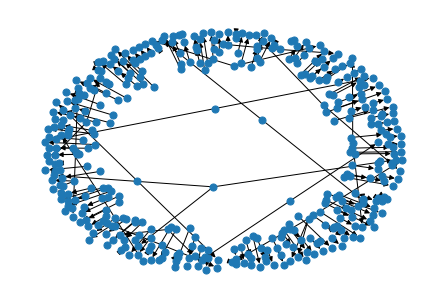

In [7]:
# Plot a sampled network

small_data = twitter_data_bully[:200]

small_network = {}
for index, row in small_data.iterrows():
  list_of_victims = row['directed_to_no_list'].split()
  small_network[row['handle']] = list_of_victims

s_G = nx.DiGraph(small_network)

nx.draw(s_G, node_size=50)

In [8]:
# Find the node with the highest degree centrality

from networkx import degree_centrality
import operator

G = nx.Graph(network)

network_deg_cent = degree_centrality(G)

max(network_deg_cent.items(), key=operator.itemgetter(1))[0]


'justinbieber'

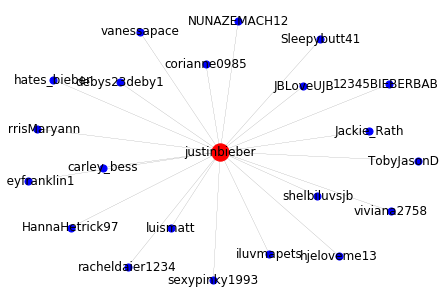

In [9]:
# Plot the bullying network of the node with the highest degree centrality

import matplotlib.pyplot as plt

hub='justinbieber'
hub_ego = nx.ego_graph(G, hub)
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color='b', node_size=50, width=0.1, with_labels=True)
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[hub], node_size=300, node_color='r')

plt.savefig("graph.png")
plt.show()

 Find Statistical Difference Using T-Test

In [10]:
import numpy as np
from scipy import stats

# Separate the bullying and non-bullying data
twitter_data_bully = twitter_data_labeled[twitter_data_labeled['pred']==True]
twitter_data_non_bully = twitter_data_labeled[twitter_data_labeled['pred']==False]

twitter_data_bully.columns

Index(['Unnamed: 0', 'comment_text', 'pred', 'account_id', 'Unnamed: 0.1',
       'handle', 'name', 'language', 'location', 'account_created_at',
       'account_created_at_interpolated', 'missing', 'followers_count',
       'following_count', 'statuses_count', 'last_post_id', 'last_post_text',
       'last_post_created_at', 'time_since_last_post', 'directed',
       'directed_to_no_list'],
      dtype='object')

In [0]:
# The mean, variance, and standard deviation of followers_count

bully_followers_mean = twitter_data_bully['followers_count'].mean()
bully_followers_var = twitter_data_bully['followers_count'].var()

nonbully_followers_mean = twitter_data_non_bully['followers_count'].mean()
nonbully_followers_var = twitter_data_non_bully['followers_count'].var()

In [0]:
# The mean, variance, and standard deviation of following_count

bully_following_mean = twitter_data_bully['following_count'].mean()
bully_following_var = twitter_data_bully['following_count'].var()

nonbully_following_mean = twitter_data_non_bully['following_count'].mean()
nonbully_following_var = twitter_data_non_bully['following_count'].var()

In [0]:
# The mean, variance, and standard deviation of statues_count

bully_statuses_mean = twitter_data_bully['statuses_count'].mean()
bully_statuses_var = twitter_data_bully['statuses_count'].var()

nonbully_statuses_mean = twitter_data_non_bully['statuses_count'].mean()
nonbully_statuses_var = twitter_data_non_bully['statuses_count'].var()

In [13]:
## T-Test (Method 1)

#Sample Size
N = 2900

#std deviation
s = np.sqrt((bully_following_var + nonbully_following_var)/2)  # can just change the parameter in the formula
 
## Calculate the t-statistics
t = (bully_following_mean - nonbully_following_mean)/(s*np.sqrt(2/N))  # can just change the parameter in the formula

## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))

t = 0.24993350224319338
p = 0.8026476287546238


Visualization

In [0]:
twitter_data_labeled = twitter_data_labeled.rename(columns={"pred": "Bully"})

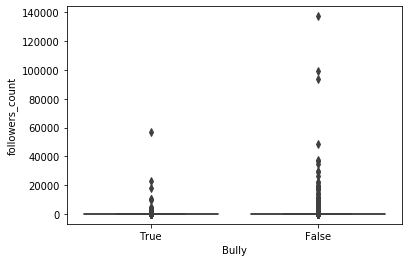

In [18]:
import seaborn as sn
bxplot = sn.boxplot(y=twitter_data_labeled['followers_count'],x=twitter_data_labeled['Bully'], order=[True, False])
plt.show()

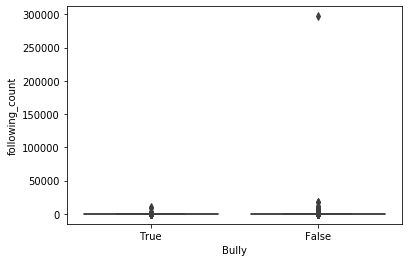

In [19]:
bxplot = sn.boxplot(y=twitter_data_labeled['following_count'],x=twitter_data_labeled['Bully'], order=[True, False])
plt.show()

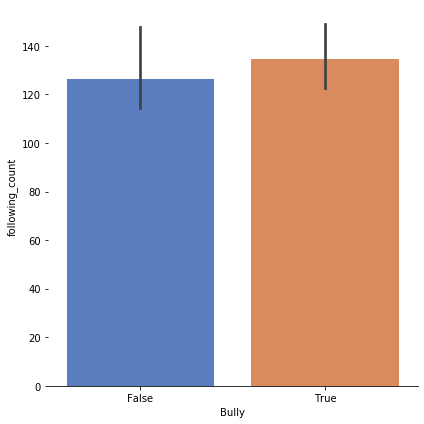

In [20]:
g = sn.catplot(x="Bully", y="following_count", data=twitter_data_labeled,
                height=6, kind="bar", palette="muted")
g.despine(left=True)

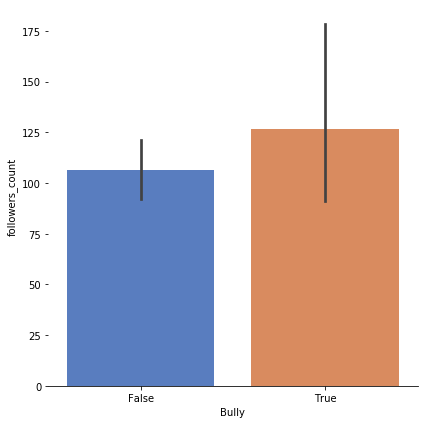

In [21]:
g = sn.catplot(x="Bully", y="followers_count", data=twitter_data_labeled,
                height=6, kind="bar", palette="muted")
g.despine(left=True)

Later on we decided to use Tableau for better visualization.